In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

print("Tensorflow version : ", tf.__version__)

Tensorflow version :  2.19.0


In [2]:
# download data
path_to_train_file = tf.keras.utils.get_file(
    'train.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
)
path_to_test_file = tf.keras.utils.get_file(
    'test.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
)

14628807/14628807 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4893335/4893335 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
train_text = open(path_to_train_file, 'rb').read().decode(encoding = 'utf-8')
test_text = open(path_to_test_file, 'rb').read().decode(encoding = 'utf-8')

print('Length of train text : {} characters'.format(len(train_text)))
print('Length of text text : {} characters'.format(len(test_text)))
print(train_text[:47])

Length of train text : 6937271 characters
Length of text text : 2318260 characters
id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0


In [4]:
train_Y = np.array([
    [int(row.split('\t')[2])]
    for row in train_text.split('\n')[1:]
    if row.count('\t') > 0
])

test_Y = np.array([
    [int(row.split('\t')[2])]
    for row in test_text.split('\n')[1:]
    if row.count('\t') > 0
])
print("train_Y shape:", train_Y.shape)
print("test_Y shape:", test_Y.shape)
print("train_Y sample:", train_Y[:5])

train_Y shape: (150000, 1)
test_Y shape: (50000, 1)
train_Y sample: [[0]
 [1]
 [0]
 [0]
 [1]]


In [5]:
import re

def clean_str(string):
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)

    return string.lower()

train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]
sentences = [sentence.split(' ') for sentence in train_text_X]
for i in range(5):
    print(sentences[i])

<>:13: SyntaxWarning: invalid escape sequence '\('
<>:14: SyntaxWarning: invalid escape sequence '\)'
<>:15: SyntaxWarning: invalid escape sequence '\?'
<>:13: SyntaxWarning: invalid escape sequence '\('
<>:14: SyntaxWarning: invalid escape sequence '\)'
<>:15: SyntaxWarning: invalid escape sequence '\?'
/tmp/ipython-input-3999841918.py:13: SyntaxWarning: invalid escape sequence '\('
  string = re.sub(r"\(", " \( ", string)
/tmp/ipython-input-3999841918.py:14: SyntaxWarning: invalid escape sequence '\)'
  string = re.sub(r"\)", " \) ", string)
/tmp/ipython-input-3999841918.py:15: SyntaxWarning: invalid escape sequence '\?'
  string = re.sub(r"\?", " \? ", string)


['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


In [6]:
VOCAB_SIZE = 2000   # 단어 사전 크기
MAX_LEN = 25        # 문장 길이 최댓값

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_LEN
)

vectorize_layer.adapt(train_text_X)
train_X = vectorize_layer(train_text_X)

print(train_X[:1])

tf.Tensor(
[[  23  902    5    1 1097    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 25), dtype=int64)


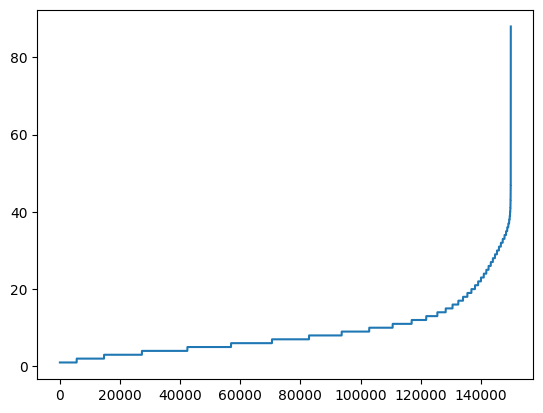

142587


In [7]:
import matplotlib.pyplot as plt
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

print(sum([int(l<=25) for l in sentence_len]))

In [8]:
test_text_X = [
    row.split('\t')[1]
    for row in test_text.split('\n')[1:]
    if row.count('\t') > 0
]

test_X = vectorize_layer(test_text_X)

print("test_X shape:", test_X.shape)
print("test_Y shape:", test_Y.shape)

test_X shape: (50000, 25)
test_Y shape: (50000, 1)


In [9]:
VOCAB_SIZE = 2000
EMBEDDING_DIM = 128
MAX_LEN = 25
EPOCHS = 10
BATCH_SIZE = 32

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(
    train_X, train_Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.6784 - loss: 0.5605 - val_accuracy: 0.7556 - val_loss: 0.4618
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7506 - loss: 0.4643 - val_accuracy: 0.7588 - val_loss: 0.4570
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7547 - loss: 0.4570 - val_accuracy: 0.7597 - val_loss: 0.4545
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7552 - loss: 0.4499 - val_accuracy: 0.7486 - val_loss: 0.4668
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7606 - loss: 0.4456 - val_accuracy: 0.7607 - val_loss: 0.4554
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7593 - loss: 0.4439 - val_accuracy: 0.7589 - val_loss: 0.4557
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7632 - loss: 0.4386 - val_accuracy: 0.7538 - val_loss: 0.4626
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7656 - loss: 0

In [13]:
test_loss, test_acc = model.evaluate(test_X, test_Y, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.4881, Test Accuracy: 0.7379


In [14]:
example_sentences = [
    "이 영화 진짜 재미",
    "완전 지루하고 별로",
    "배우 연기는 좋았는데, 스토리가 아쉽"
]

example_seq = vectorize_layer(example_sentences)
pred = model.predict(example_seq)

for s, p in zip(example_sentences, pred):
    print(f"문장: {s}")
    print(f"긍정 확률: {p[0]:.4f}")
    print("결과:", "긍정 😊" if p[0] > 0.5 else "부정 😞")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
문장: 이 영화 진짜 재미
긍정 확률: 0.3069
결과: 부정 😞
문장: 완전 지루하고 별로
긍정 확률: 0.0026
결과: 부정 😞
문장: 배우 연기는 좋았는데, 스토리가 아쉽
긍정 확률: 0.0408
결과: 부정 😞


In [24]:
# 실습 미션 코드를 작성해주세요.
# 1. Epoch=30 으로 늘려 모델 학습
# 2. matplotlib를 이용하여 Epoch 10 과 Epoch 30을 비교하여 시각화
history2 = model.fit(
    train_X, train_Y,
    epochs=30,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8090 - loss: 0.3588 - val_accuracy: 0.7435 - val_loss: 0.5577
Epoch 2/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8097 - loss: 0.3563 - val_accuracy: 0.7347 - val_loss: 0.5656
Epoch 3/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8114 - loss: 0.3513 - val_accuracy: 0.7412 - val_loss: 0.5711
Epoch 4/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8125 - loss: 0.3479 - val_accuracy: 0.7466 - val_loss: 0.5710
Epoch 5/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8142 - loss: 0.3462 - val_accuracy: 0.7420 - val_loss: 0.5882
Epoch 6/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8144 - loss: 0.3447 - val_accuracy: 0.7342 - val_loss: 0.5881
Epoch 7/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8176 - loss: 0.3386 - val_accuracy: 0.7371 - val_loss: 0.5882
Epoch 8/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8181 - loss: 0

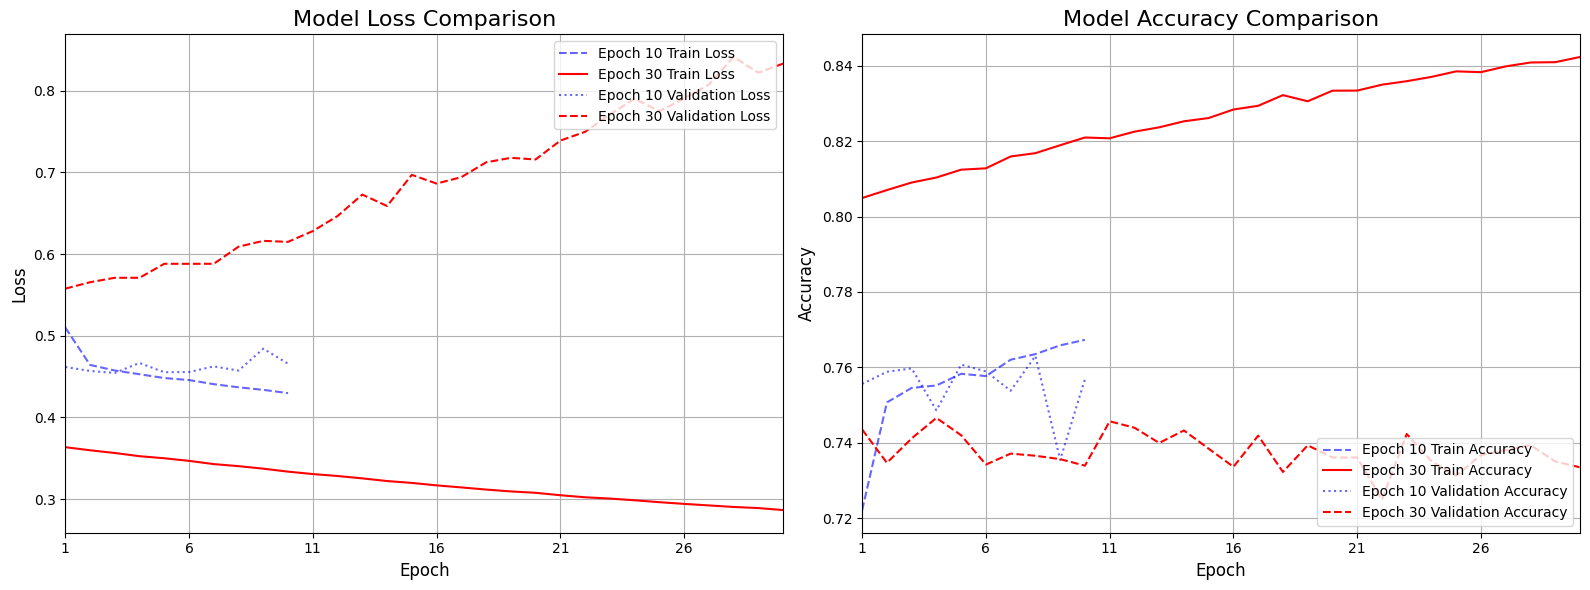

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# X축 범위 및 눈금 설정을 위한 0부터 29까지의 인덱스 생성
epochs_30 = np.arange(0, len(history2.history['loss']))
# 사용자에게 보여줄 Epoch 레이블 (1부터 30까지)
epoch_labels = np.arange(1, 31, 5) # 1, 6, 11, ... 26
# X축 눈금 위치 (0, 5, 10, ... 25)
tick_positions = np.arange(0, 30, 5)

plt.figure(figsize=(16, 6)) # 전체 그림 크기를 더 키워서 가독성 향상

# ----------------------------------------------------------------------
# 1. 손실(Loss) 그래프 (왼쪽)
# ----------------------------------------------------------------------
plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째 플롯

# 훈련 손실 데이터 Plot
plt.plot(np.arange(0, len(history.history['loss'])), history.history['loss'],
         label='Epoch 10 Train Loss', linestyle='--', color='blue', alpha=0.6)
plt.plot(epochs_30, history2.history['loss'],
         label='Epoch 30 Train Loss', linestyle='-', color='red')

# 검증 손실 데이터 Plot
plt.plot(np.arange(0, len(history.history['val_loss'])), history.history['val_loss'],
         label='Epoch 10 Validation Loss', linestyle=':', color='blue', alpha=0.6)
plt.plot(epochs_30, history2.history['val_loss'],
         label='Epoch 30 Validation Loss', linestyle='--', color='red')

# X축 설정 (30 Epoch까지 표시)
plt.xlim([0, 29])
plt.xticks(tick_positions, labels=epoch_labels)

plt.title('Model Loss Comparison', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)

# ----------------------------------------------------------------------
# 2. 정확도(Accuracy) 그래프 (오른쪽)
# ----------------------------------------------------------------------
plt.subplot(1, 2, 2) # 1행 2열 중 두 번째 플롯

# 훈련 정확도 데이터 Plot
plt.plot(np.arange(0, len(history.history['accuracy'])), history.history['accuracy'],
         label='Epoch 10 Train Accuracy', linestyle='--', color='blue', alpha=0.6)
plt.plot(epochs_30, history2.history['accuracy'],
         label='Epoch 30 Train Accuracy', linestyle='-', color='red')

# 검증 정확도 데이터 Plot
plt.plot(np.arange(0, len(history.history['val_accuracy'])), history.history['val_accuracy'],
         label='Epoch 10 Validation Accuracy', linestyle=':', color='blue', alpha=0.6)
plt.plot(epochs_30, history2.history['val_accuracy'],
         label='Epoch 30 Validation Accuracy', linestyle='--', color='red')

# X축 설정 (30 Epoch까지 표시)
plt.xlim([0, 29])
plt.xticks(tick_positions, labels=epoch_labels)

plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right', fontsize=10) # 정확도는 값이 높으므로 범례 위치 조정
plt.grid(True)

plt.tight_layout() # 그래프 간격 자동 조정
plt.show()